# Develop Model
In this notebook we are going to go through the steps to develop the code around our model (ResNet152). We will look at how to load the model, process the data into an appropriate format and call it.

In [1]:
import numpy as np
import tensorflow as tf
from IPython.display import Image as show_image
from PIL import Image
from tensorflow.contrib.slim.nets import resnet_v1

We download the model checkpoint.

In [2]:
!wget http://download.tensorflow.org/models/resnet_v1_152_2016_08_28.tar.gz

--2018-05-27 23:41:34--  http://download.tensorflow.org/models/resnet_v1_152_2016_08_28.tar.gz
Resolving download.tensorflow.org... 172.217.15.80, 2607:f8b0:4004:804::2010
Connecting to download.tensorflow.org|172.217.15.80|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 224342140 (214M) [application/x-tar]
Saving to: 'resnet_v1_152_2016_08_28.tar.gz'

resnet_v1_152_2016_ 100%[===================>] 213.95M   217MB/s    in 1.0s    

2018-05-27 23:41:35 (217 MB/s) - 'resnet_v1_152_2016_08_28.tar.gz' saved [224342140/224342140]



In [3]:
!tar xvf resnet_v1_152_2016_08_28.tar.gz

resnet_v1_152.ckpt


We download the synset for the model. This translates the output of the model to a specific label.

In [4]:
!wget "http://data.dmlc.ml/mxnet/models/imagenet/synset.txt"

--2018-05-27 23:41:39--  http://data.dmlc.ml/mxnet/models/imagenet/synset.txt
Resolving data.dmlc.ml... 54.208.175.7
Connecting to data.dmlc.ml|54.208.175.7|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 31675 (31K) [text/plain]
Saving to: 'synset.txt'

synset.txt          100%[===================>]  30.93K  --.-KB/s    in 0.001s  

2018-05-27 23:41:40 (27.0 MB/s) - 'synset.txt' saved [31675/31675]



This is how we will call our model. We first create the input placeholder for our input image. The dimensions of the image are 224 by 224 and has three color channels.

In [5]:
# Placeholders
input_tensor = tf.placeholder(tf.float32, shape=(None,224,224,3), name='input_image')

In [6]:
# Load the model
sess = tf.Session()
arg_scope = resnet_v1.resnet_arg_scope()
with tf.contrib.slim.arg_scope(arg_scope):
    logits, _ = resnet_v1.resnet_v1_152(input_tensor, num_classes=1000, is_training=False)

Instructions for updating:
keep_dims is deprecated, use keepdims instead


To get probabilities we add the softmax layer.

In [7]:
probabilities = tf.nn.softmax(logits)

Here we load thre pretrained weights we downloaded earlier into the model.

In [8]:
checkpoint_file = 'resnet_v1_152.ckpt'
saver = tf.train.Saver()
saver.restore(sess, checkpoint_file)

INFO:tensorflow:Restoring parameters from resnet_v1_152.ckpt


Let's test our model with an image of a Lynx

In [9]:
!wget https://upload.wikimedia.org/wikipedia/commons/thumb/6/68/Lynx_lynx_poing.jpg/220px-Lynx_lynx_poing.jpg

--2018-05-27 23:41:49--  https://upload.wikimedia.org/wikipedia/commons/thumb/6/68/Lynx_lynx_poing.jpg/220px-Lynx_lynx_poing.jpg
Resolving upload.wikimedia.org... 208.80.154.240, 2620:0:861:ed1a::2:b
Connecting to upload.wikimedia.org|208.80.154.240|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 27183 (27K) [image/jpeg]
Saving to: '220px-Lynx_lynx_poing.jpg'

220px-Lynx_lynx_poi 100%[===================>]  26.55K  --.-KB/s    in 0.002s  

2018-05-27 23:41:49 (14.2 MB/s) - '220px-Lynx_lynx_poing.jpg' saved [27183/27183]



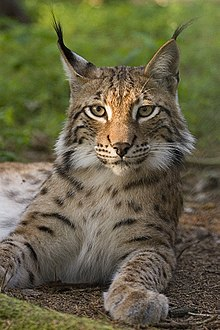

In [10]:
show_image("220px-Lynx_lynx_poing.jpg")

We load the image, resize it and transform it into an array

In [11]:
im = Image.open("220px-Lynx_lynx_poing.jpg").resize((224,224))
im = np.array(im)
im = np.expand_dims(im, 0)

We run it against the model and get the predictions

In [12]:
pred, pred_proba = sess.run([logits,probabilities], feed_dict={input_tensor: im})

We take the top three predictions and get the appropriate labels for them.

In [13]:
def create_label_lookup():
    with open('synset.txt', 'r') as f:
        label_list = [l.rstrip() for l in f]
    def _label_lookup(*label_locks):
        return [label_list[l] for l in label_locks]
    return _label_lookup

In [14]:
label_lookup = create_label_lookup()

In [15]:
top_results = np.flip(np.sort(pred_proba.squeeze()), 0)[:3]

In [16]:
labels=label_lookup(*np.flip(np.argsort(pred_proba.squeeze()), 0)[:3])

The top guess is Lynx with a probability of 99.8%

In [17]:
dict(zip(labels, top_results))

{'n02123159 tiger cat': 0.00079028757,
 'n02124075 Egyptian cat': 0.0008608107,
 'n02127052 lynx, catamount': 0.9979292}

We can move onto [deploy on AKS](01_DeployOnAKS.ipynb)